# Cure Kinetics (28 points)

#### Authors

### As it was explained during the lectures, a significant part of research in composites manufacturing is involved in analyzing curing processes of thermoset polymers.Thermoset resins, such as epoxy, undergo a curing process driven by chemical reactions. These reactions result in the creation of covalent bonds among monomers, ultimately forming polymer chains. This curing process is quantified by the parameter known as the 'degree of cure,' denoted as $\alpha$. Initially, in the absence of any covalent bonds, the material consists solely of individual monomers. In this scenario, it can be asserted that no bonding has occurred, resulting in $\alpha = 0$. However, upon the addition of a hardener, the monomers initiate the formation of polymer chains through the establishment of covalent bonds. When all the monomers have become part of polymer chains through these covalent bonds, it is deemed that the degree of cure has reached its maximum, $\alpha = 1$

### Chemical reactions occur through contact of two active groups belonging to different molecules (for example of epoxy and of a hardener). Elevated cure temperatures are essential to trigger and maintain the chemical reactions responsible for converting the thermoset into a fully cured state. Whenever resin and hardener molecules (after mixing) are provided with more kinetic energy, they are more likely to shift and collide with neighbouring molecules, increasing the chances of curing reactions. Additionally, when more time is given to two reactants, the probability of a necessary collision for bonding increases. As a result, these phenomena are highly influenced by resin chemistry, catalyst reactivity, cure temperature, and the presence of inhibitors or accelerators.

### Therefore, we can say that the degree of cure $\alpha$ is a function of both temperature and time. $$\alpha = f(T,t)$$

#### Cure kinetics is concerned with the rates of the chemical reactions in a curing process. This is relevant, since the cure kinetics can help predict the thermoset cure and therefore also determines the manufacturing process and (partially) the final material properties. When cure kinetics are understood, they can be used to predict the degree of cure $\alpha$ of a certain process. To make this type of prediction, DSC measurement data can be used.

#### Before starting to work on the questions and to achieve a better understanding of the topic, it is highly recommended for you to read the paper provided with this notebook (Kailong Jin, William H. Heath, John M. Torkelson, Kinetics of multifunctional thiol-epoxy click reactions studied by differential scanning calorimetry: Effects of catalysis and functionality. Polymer. 2015; 81: 70-78).

## Question 1 (1 point)

#### Differential Scanning Calorimetry (DSC) experiments are frequently used to evaluate the cure kinetics parameters involved in the curing of thermosets. To show this correlation, three tests were performed in isothermal conditions for the polymerization of a thermoset at three different temperatures. The .xlsx files which contain these raw isothermal DSC measurements were attached to this notebook.
#### In the cell below, plot the relevant DSC measurement data for all of the three cases in a single figure. Don't forget to label the axis (ylabel = H[W/g], xlabel=t[min]).
#### NOTE: 
#### 1. The unit used for heat flow data in the .xlsx files is [mW/s].
#### 2. The weights for the specimens are mentioned in the respective .xlsx files.
#### 3. Data analysis needs to be carried out in order to determine what is relevant and what is machine data/noise. Carry out cleaning of data if necessary. Mention the steps followed (if applicable) as part of your answers.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp

---------READING FILE-----------
---------FILE READ---------
---------READING FILE-----------
---------FILE READ---------
---------READING FILE-----------
---------FILE READ---------


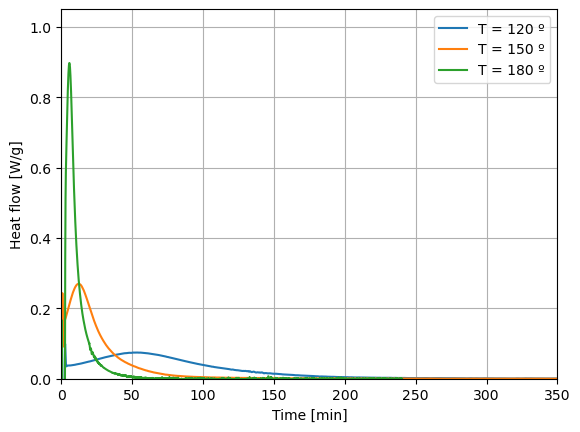

In [3]:
# File names
file_120 = "LME_0_13_120.xlsx"
s_name_120 = "Sheet1"
file_150 = "LME_0_12b_150.xlsx"
s_name_150 = "Sheet1"
file_180 = "LME_0_11_180.xlsx"
s_name_180 = "Sheet1"


## to DO FILTER DATA
def read_file(file_name, sheet_name, wl):
    # Function that reads the correct file and gives the required data
    # ATTENTION: the file need sto be in the same folder as the code
    # Input: File name, sheet name, final value to read from the rows in the excel +1 (final row+ 1)
    # Outputs : time list, filtered heat flow, temperature iof the sample
    print("---------READING FILE-----------")
    dfv = pd.read_excel(file_name,sheet_name=sheet_name, usecols="B",header=None, skiprows=0, nrows=25)
    # Reading of the specific points
    weight = float(dfv.iloc[7, 0])             # [mg]
    weight = weight/1000

    n_point= int(dfv.iloc[21, 0])+37           # Number of rows to read

    # Caluclation of all the reange that need sto be read
    l_num = n_point-35
   
    
    # reading of the file for 
    df = pd.read_excel(file_name,sheet_name=sheet_name, usecols="B, C, F",header=None, skiprows=0, nrows=l_num)
    print("---------FILE READ---------")
    # Creation of the lists
    time = df.iloc[35:-1, 0].tolist()            # [min]
    heat_flow_unsub = df.iloc[35:-1, 1].tolist() # [mW]
    #program_t = df.iloc[0:-1, 2].tolist()       # [C]
    sample_t = df.iloc[35:-1, 2].tolist()        # [C]
    #approx_gas_flow = df.iloc[0:-1, 4].tolist() # [-]
    #heat_flow_cali = df.iloc[0:-1, 5].tolist()  # [-]


    # Conversion into np arrays and into the correct units
    time_list= np.array(time, dtype=float)              # [min]
    sample_t_list = np.array(sample_t, dtype = float)
    sample_t_list = np.array(sample_t, dtype=float)
    heat_flow_unsub_list = np.array(heat_flow_unsub, dtype=float)
    heat_flow_unsub_list = heat_flow_unsub_list/1000    # [W]

    # Conversion from W/s to W/g as an accumulation of heat
    time_list = time_list*60
    sample_t_list = sample_t_list+273.15
    """ tot_h = np.zeros(len(time_list))
    for i in range(len(heat_flow_unsub_list)):
        if i == 0: 
            dt = time_list[i] * 60
            tot_h[i] = heat_flow_unsub_list[i] * dt     # [W]
            
        else:
            dt = (time_list[i]-time_list[i-1]) * 60
            tot_h[i] = heat_flow_unsub_list[i] * dt     # [W]
            """
    # devide by weight
    heat_flow_unsub_list = heat_flow_unsub_list/weight # [W/g]


    # Filtering of the data
    filtered_tot_h_flow = savgol_filter(heat_flow_unsub_list, window_length=wl, polyorder=3)
    filtered_tot_h_flow = filtered_tot_h_flow - filtered_tot_h_flow[int(len(filtered_tot_h_flow)*0.95)]
    return time_list, filtered_tot_h_flow, sample_t_list#, program_t, sample_t, approx_gas_flow, heat_flow_cali

def plot_DSC (t_120, hf_120, t_150, hf_150, t_180, hf_180):
    # Fuunction in order to plot the DSC graphs
    # Inputs: time array 120, heat flow array 120, time arrray 150, heat flow array 150m, time array 180, heat flow array 180
    # Output: plot

    
    t_120 = t_120/60
    t_150 = t_150/60
    t_180 = t_180/60
    plt.plot(t_120, hf_120, label = "T = 120 º")
    plt.plot(t_150, hf_150, label = "T = 150 º")
    plt.plot(t_180, hf_180, label = "T = 180 º")
    plt.xlim(0, 350)
    plt.ylim(bottom = 0)
    plt.ylabel("Heat flow [W/g]")
    plt.xlabel("Time [min]")
    plt.legend()
    plt.grid()
    plt.savefig("DSC.jpg")
    plt.show()
    
    return


# QUESTION 1
t_120, hfu_120, T_120= read_file(file_120, s_name_120, 101)
t_150, hfu_150, T_150= read_file(file_150, s_name_150, 101)
t_180, hfu_180, T_180= read_file(file_180, s_name_180, 71)
plot_DSC(t_120, hfu_120, t_150, hfu_150, t_180, hfu_180)


## Question 2 (2 points)

#### After visualizing the heat generation curves, explain why and how isothermal DSC measurement data can be related to the curing rate of a thermoset resin. Why is there a peak and what can it be related to?

Answer: Curing of a thermoset resin is an exothermic process due to forming of cross-links. The energy released by the forming of these cross-links is emitted as heat which in turn can be measured by the DSC (heat flow). The relation can be described as Measured heat flow ∝ Reaction rate or better with (dQ)\(dt) = ΔH_{total} * (dα)/(dt) Where dα = curing rate, because α = degree of cure (fraction cured (ranging from 0-1)).

The curing process is not constant and can be divided into 4 phases:

    1) Start (low heat flow): Before initiation some cross-links are formed over time but negligible.
    2) Increase (increasing heat flow): After initiation, more cross-links are formed creating more heat/energy which helps with forming other cross-links. dα/dt keeps increasing.
    3) Peak (max heat flow): dα/dt reaches its peak, highest amount of reactions taking place.
    4) Decrease (reducing heat flow): Due to restriction in mobility due to the cross-links. A network is formed by the cross-links, making it harder for the remaining cross-links to find a 'space' to link onto another polymer.

Chemically, it can best be described by the autocatalytic behaviour, which keeps increasing dα/dt until the negative effect of the diffusion limitations matches the positives of the autocatalic behaviour. From that point onwards, the diffusion will keep increasing, decreasing the number of reactions and decreasing dα/dt. Therefore going over the peak that is shown in the DSC measurement.

## Question 3 (4 points)

#### As mentioned, the just plotted isothermal DSC data  can be used to obtain an estimation of degree of cure $\alpha$ vs. time $t$. To do so, it first has to be assumed that the heat flow is proportional to the degree of cure.  $$\Delta H_{max} \equiv \alpha = 1$$
#### Where  $\Delta H_{max} $ identifies the maximum total heat of reaction found for the three DSC measurements.
#### $\Delta H_{max} = max(\Delta H_{max_{120}}, \Delta H_{max_{150}}, \Delta H_{max_{180}})$
#### Overall, the formula above expresses how the total generated heat flow while curing corresponds to a complete degree of cure for the reaction (100%).
#### Then, this assumption is used to normalize the heat flow measurement. This normalized heat flow can now be related to the curing rate. $$\frac{d\alpha}{dt} = \frac{1}{\Delta H_{max}} \frac{dH(t)}{dt}$$
#### Finally, integrating this result leads to the relationship of the degree of cure $\alpha$ vs. time $t$.

#### Use the assumptions and information provided above to plot the degree of cure $\alpha$ vs. time $t$, using the provided data. Plot all cases in a single figure. Make sure to plot over a time interval which suits the results, include a legend and axes labels with units.

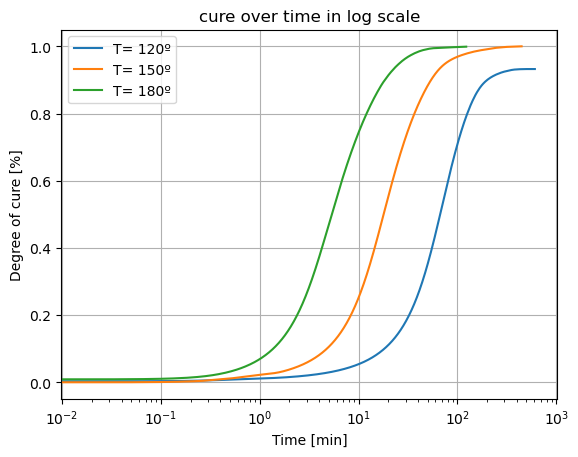

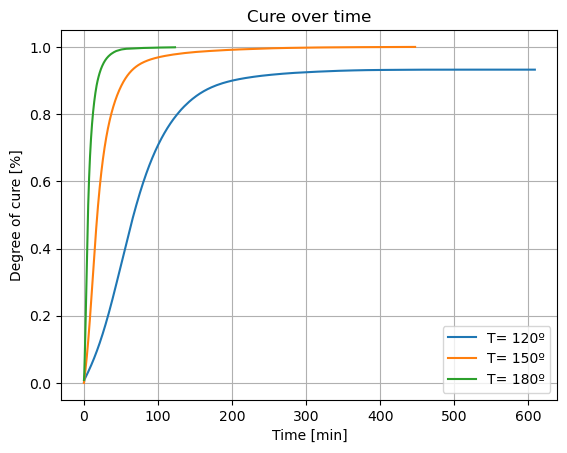

Enthalpy relase for 120º= 458.9482478988116 , For 150º=  492.230524707017 For 180º=  491.70566823892693


In [4]:
# Add the max heat
def heat_add(h_flow, time, T, T_req):
    # Function that integrates the heat flow over time in order to the total amount of heat from the exothermal reaction, and stores teh temperatures for future processing
    # Inputs: Heat flow array in W, tiem array in second, temperature
    # Outputs: degree of cure array

    len_arr = np.count_nonzero(h_flow>0.0000000)          # Lenght of the array positive  [int] filtering the very small initial value
    #tot_h = np.zeros(len_arr)   # List of the heat flow
    #positive_time = np.zeros(len_arr)
    tot_h = []
    positive_time = []
    T_list = []
    tp = 0                      # Time varaible for calculation
    hp = 0                      # Heat variable for calculation
    q = True                       # variable for shifting time
    # Make sure that it has achived the temperature of the isothermal
    for i in range(len_arr):
        if (h_flow[i]>0.0000000 and T[i]>T_req):                      # We asume that if the heat is negative that means that there is no reactions happening and that the that shouldnt be taken into account for the curing
            if q==True:
                ft=time[i]
                q=False
            h_t = h_flow[i]*(time[i] - tp)
            
            tp = time[i]
            tot_h.append( h_t + hp)
            positive_time.append( time[i]-ft)   # Normalize the time so that it starts at the first curing time
            T_list.append(T[i])
            hp = h_t + hp 

    # If we look in detail at the line for 180 deg we see that it is not filtereed perfectly. This actually okay, If we look at the amount of cure after it crosses 0 for the first time the degree of cure does not change that much
    # CURE KINETICS MODELS ARE LEATIVE
    return tot_h , positive_time, T_list

def plot_cure(t120, a_t_120, t150, a_t_150, t180, a_t_180):
    # Fuunction in order to plot the DSC graphs
    # Inputs: time array 120, heat flow array 120, time arrray 150, heat flow array 150m, time array 180, heat flow array 180
    # Output: plot
    t120 = np.array(t120)/60
    t150 = np.array(t150)/60
    t180 = np.array(t180)/60
    plt.plot(t120, a_t_120, label = "T= 120º")
    plt.plot(t150, a_t_150, label = "T= 150º")
    plt.plot(t180, a_t_180, label = "T= 180º")
    plt.grid()
    plt.title("cure over time in log scale")
    plt.xlabel("Time [min]")
    plt.xscale("log")
    plt.ylabel("Degree of cure [%]")
    plt.legend()
    plt.savefig("Cure.jpg")
    plt.show()

    plt.plot(t120, a_t_120, label = "T= 120º")
    plt.plot(t150, a_t_150, label = "T= 150º")
    plt.plot(t180, a_t_180, label = "T= 180º")
    plt.grid()
    plt.title("Cure over time")
    plt.xlabel("Time [min]")
    plt.ylabel("Degree of cure [%]")
    plt.legend()
    plt.savefig("Cure.jpg")
    plt.show()
    
    return

# QUESTION 3
heat_120 , pos_t_120, rT120= heat_add(hfu_120, t_120, T_120, 120+273.15)
heat_150 , pos_t_150, rT150= heat_add(hfu_150, t_150, T_150, 150+273.15)
heat_180 , pos_t_180, rT180= heat_add(hfu_180, t_180, T_180, 150+273.15)

# fin the maximum heat
max_heat = max(heat_120[-1], heat_150[-1], heat_180[-1])
alpha_t_120 = heat_120/max_heat
alpha_t_150 = heat_150/max_heat
alpha_t_180 = heat_180/max_heat
print
plot_cure(pos_t_120, alpha_t_120, pos_t_150, alpha_t_150, pos_t_180, alpha_t_180)
print("Enthalpy relase for 120º=", heat_120[-1],", For 150º= ", heat_150[-1],"For 180º= ", heat_180[-1])

## Question 4 (4 points)

#### Question 4.1: In the previous question you have generated graphs illustrating the relationship between the degree of cure $\alpha$ and time t for three isothermal DSC measurements carried out at different temperatures. Provide your analysis regarding the maximum degree of cure visible in the generated graphs. Can you explain the correlation between the final degree of cure and cure temperature? 

Answer: For 180 and 150 degrees it approaches 100% cure whilst 120 degrees does not reach this and seems to approach just above 90% cure. As can also be seen in the graph is that da/dt is greater with higher temperatures. 

The correlation between final degree of cure and cure temperature can be described by:
Higher cure temperature results in a higher conversion, however the returns deminish towards the higher temperatures.

#### Question 4.2 : A graph correlating the degree of cure $\alpha$ with cure time for isothermal cure cycles at six different cure temperatures is shown in the figure below. Compare your graph made in Question 3 with the given figure. Describe two similarities and at least one difference. Provide a potential reason for the difference(s) you observed.

Conversion vs. ln(time) curves for an epoxy-amine system. From Wisanrakkit and Gillham, J. Appl. Poly. Sci. 42, 2453 (1991)
<img src="Conversion-time-plot.jpg" width="700" height="400">

Answer:
Simularity 1) The overal trend/shape of the graphs are equal
Simularity 2) 120 degrees never approaches the 1.0 conversion and levels just above 90% 

Difference: The conversion of the 150 degree cure cycle in our case goes over the conversion of our 180 degree whilst it is clear in the figure shown above that the conversion lines never cross. We believe that the error is either in our data (measurement errors) or a numerical error due to the computation done with the data.

## Question 5 (7 points)

#### Several cure kinetics models were formulated to predict and simulate experimental cure profiles of thermosetting resins in terms of curing rate. You will be putting to test one of the most widely used ones: the Kamal-Sourour model (shown below) $$\frac{d\alpha}{dt} = (k_1 + k_2 \cdot \alpha^m)(1 - \alpha)^n$$
#### Where $k_1$ and $k_2$ are rate constants, and  $m$ and $n$ are reaction orders.
#### The reaction rate constants $k_1$ and $k_2$ strongly depend on cure temperature and follow an Arrhenius type relation, as shown by the equation:
$$k_i = A_i \cdot exp(-\frac{E_i}{RT})$$
$$i=1,2$$
#### Where the pre-exponential factor $A_i$ represents a constant, $E_i$ is the activation energy (mol/J), R is the molar gas constant and T is the cure temperature.

#### Question 5.1: Using the experimental isothermal DSC data used in Question 1, you will set up the cure kinetics of the resin based on the Kamal Sourour model. To estimate the intial activation energy $E_1$ and $A_1$, plot $ln\left(\frac{d\alpha}{dt}\right)$ vs $\frac{1}{T}$ for a low degree of cure based on the three DSC measurements given. Calculate $E_1$ and $A_1$ based on the graph.

#### Hint: $\alpha \approx 0$

 Mean square root error of first interpolation =  1.1247093552718703e-16
 Mean square root error of second interpolation =  1.2825061946164708e-16
 Mean square root error of third interpolation =  1.384843388368368e-16


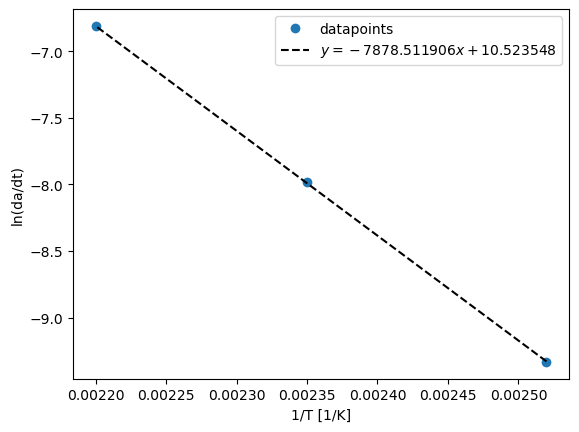

A1 = 37180.811636420956
E1 = 65505.592729937736


In [5]:
def Kamal_Sourour (cure1, t1, T1, cure2, t2, T2, cure3, t3, T3):
    # Function to calulate E1 A1  using the kamal sourour model
    # Inputs = cure over time array, time array corresponding to cure, Temparature of sample over time Gas constant
    # Output = plot the linear regression, coefficent A coefficent E, da/dt120 array, da/dt150 array,da/dt180 array

    # In order to get the coeffinect A1 and E1 we can solve the system of equations for aplpha alspmost 0:
    # da/dt_1 = A_1 e( E_1/RT)

    R = 8.31446261815324 # [J⋅K−1⋅mol−1]

    # Find spline interpolation for later derivation at alpha = 0
    c1 = InterpolatedUnivariateSpline(t1, cure1)
    c1int= c1(t1)
    c2 = InterpolatedUnivariateSpline(t2, cure2)
    c2int= c2(t2)
    c3 = InterpolatedUnivariateSpline(t3, cure3)
    c3int= c3(t3)
    # Check for mean square error of the interpolation
    error1 = cure1 - c1int
    rmse1 = np.sqrt(np.mean(error1**2))
    error2 = cure2 - c2int
    rmse2 = np.sqrt(np.mean(error2**2))
    error3 = cure3 - c3int
    rmse3 = np.sqrt(np.mean(error3**2))
    print(" Mean square root error of first interpolation = ", rmse1)
    print(" Mean square root error of second interpolation = ", rmse2)
    print(" Mean square root error of third interpolation = ", rmse3)
    


    dc1_dt1 = c1.derivative()(t1)
    dc2_dt2 = c2.derivative()(t2)
    dc3_dt3 = c3.derivative()(t3)
    # Derivative when cure is 0

    # Malke a loop untill the rms reduces by
    a_max=0.01# Max alpha to asume that curing is still 0
    r_l = [] # List of the mean square error
    a_l = []   # List for the curing taken
    run = True
    while a_max<=0.1 and run==True:
        # take the avearge ofer the Check 
        # lenght of averaged da/dt and T
        l_avg1 = calc_t_a (cure1, a_max)
        l_avg2 = calc_t_a (cure2, a_max)
        l_avg3 = calc_t_a (cure3, a_max)
        dc1_dt1_0 = np.mean(dc1_dt1[0:l_avg1])
        dc2_dt2_0 = np.mean(dc2_dt2[0:l_avg2])
        dc3_dt3_0 = np.mean(dc3_dt3[0:l_avg3])
        
        T_1_0 = np.mean(T1[0:l_avg1])
        T_2_0 = np.mean(T2[0:l_avg2])
        T_3_0 = np.mean(T3[0:l_avg3])
    
        # Make a linear fit of the  ln(da/dt) over 1/T
        l_dc_dt = np.array([np.log(dc1_dt1_0), np.log(dc2_dt2_0), np.log(dc3_dt3_0)])
        l_t =np.array([1/T_1_0, 1/T_2_0, 1/T_3_0])
        coef = np.polyfit(l_t, l_dc_dt, 1)
        poly1d_fn = np.poly1d(coef)

        # calculate prediction of the line
        y = l_dc_dt
        y_pred = coef[0]*l_t+ coef[1]
        SS_res = np.sum((y - y_pred)**2)
        SS_tot = np.sum((y - np.mean(y))**2)
        R2 = 1 - SS_res / SS_tot

        #Calculate  normalized means square root error
        
        r_l.append(R2)
        a_l.append(a_max)
        
        if R2 >0.99999 and a_max>0.001: # Stop when the relation between the new rms and the previous is of les than 2 %
            print("Curing range used= [0,",a_max,"], R^2= ", R2 )
            run= False
            
        a_max = a_max + 0.001
    """    plt.plot(a_l, r_l)
    plt.ylabel("R^2")
    plt.xlabel("Cure range taken")
    plt.grid()
    plt.show()"""

    # plot 
    plt.plot(l_t, l_dc_dt, "o", label = "datapoints")
    plt.plot(l_t, poly1d_fn(l_t), '--k', label=f'$y = {coef[0]:f}x + {coef[1]:f}$')
    plt.ylabel("ln(da/dt)")
    plt.xlabel("1/T [1/K]")
    plt.legend()
    plt.show()


    # Calculate coefficnets
    A = np.exp(coef[1])     # b = ln(A)
    E = - R * coef[0]       # a = -E/R
    print("A1 =", A)
    print("E1 =", E)

    return dc1_dt1, dc2_dt2, dc3_dt3, A, E

def calc_t_a(cure, a):
    # Function that calculate sthe amount of time untill a certain value of cure is achived
    # Input = cure array, time array, cure top limit
    # Output = integer the amount values to take into account for averaging
    for i in range (len(cure)): 
        
        if cure[i]>= a:
            m= int(i-1)
            break
    return m


def find_kamal_sour(da_dt120, T_120, c_120, da_dt180, T_180, c_180, A1, E1):
    # Function to find the arhenious terms A2, E2, m and n through minimization of the sum of squares of residuals of the two functions
    # Inputs = da/dt(120) array, temperature for 120 array, cure 120 array, da/dt(180) array, temperature for 180 array, cure 180 array, A1 and E1
    # Outputs = A2, E2, m, n all floats

    R = 8.31446261815324 # [J⋅K−1⋅mol−1]

    # Combine the sets of curing, temperature and d alpha dt
    a_all = np.concatenate([c_120, c_180])
    T_all = np.concatenate([T_120, T_180])
    da_dt_all = np.concatenate([da_dt120, da_dt180])

    # Choose intital parameters: They have to be resonable (in this casew the initial guesses are from from the article)
    p0 = [      7,     # A2
      50000,   # E2 (J/mol)
      2.0,     # m
      1.0]     # n
    
    # Add bounds:
    bounds = ( [0,   1e4, 0.1, 0.1], [1e8, 2e5, 5.0, 5.0] )
    # run the fitting
    print("---------------Fitting started---------------")
    popt, pcov = curve_fit(
    wrapper,
    (a_all, T_all),  # independent variables
    da_dt_all,       # dependent variable
    p0=p0,
    bounds=bounds,
    maxfev=50000)
    print("---------------Fitting eneded---------------")

    # extract parameters
    A2_fit, E2_fit, m_fit, n_fit = popt
    print("Fitted parameters:")
    print("A2 =", A2_fit)
    print("E2 =", E2_fit)
    print("m  =", m_fit)
    print("n  =", n_fit)


    # Compariuosn with experimental results
    da_dt120_fit = calc_da_dt(T_120, c_120, A1, E1, A2_fit, E2_fit, m_fit, n_fit)
    da_dt180_fit = calc_da_dt(T_180, c_180, A1, E1, A2_fit, E2_fit, m_fit, n_fit)
    a120r = calc_area(c_120, da_dt120)
    a180r = calc_area(c_180, da_dt180)
    a120f = calc_area(c_120, da_dt120_fit)
    a180f = calc_area(c_180, da_dt180_fit)

    plt.plot(c_120, da_dt120, label = "Data of 120º")
    plt.plot(c_180, da_dt180, label = "Data of 180º")
    plt.plot(c_120, da_dt120_fit, label ="Curve fit 120º")
    plt.plot(c_180, da_dt180_fit, label ="Curve fit 180º")
    plt.ylabel("da/dt")
    plt.xlabel("Cure")
    plt.grid()
    plt.legend()
    plt.show()

    # relative difference between real data and fitted data
    r120 = abs(a120f-a120r)/a120r*100
    r180 = abs(a180f-a180r)/a180r*100
    print("Relative difference between fitted curve and real curve for 120º= ", r120, "%")
    print("Relative difference between fitted curve and real curve for 180º= ", r180, "%")
    return A2_fit, E2_fit, m_fit, n_fit

def rate_model(a, T, A1, E1, A2, E2, m, n):
    # Function of the Kamal Sourour
    R = 8.31446261815324 # [J⋅K−1⋅mol−1]

    # Keep a in numerical range
    a = np.clip(a, 1e-12, 1 - 1e-12)
    # Safe exponential
    def safe_exp(x):
        return np.exp(np.clip(x, -700, 700))
    term1 = A1 * safe_exp(-E1 / (R * T))
    term2 = A2 * safe_exp(-E2 / (R * T)) * a**m

    return (term1 + term2) * (1 - a)**n
    
    """return (A1*np.exp(-E1/(R*T)) + A2*np.exp(-E2/(R*T)) * a**m) * (1 - a)**n"""

def wrapper(x, A2, E2, m, n):
    # Function to be able to pass more variables than one in curve_fit
    a, T = x
    return rate_model(a, T, A1, E1, A2, E2, m, n)

def calc_da_dt(T, C, A1, E1, A2, E2, m, n):
    # Function to calculate the da/dt with the previously calculated paramters
    # Input = Temperature array, Curing array, A1, E1, A2, E2, m, n
    # Output = array with the da/dt

    R = 8.31446261815324 # [J⋅K−1⋅mol−1]
    da_dt_fit = np.zeros(len(C))
    for i in range (len(C)):
        k1 = A1 * np.exp(-E1/(R*T[i]))
        k2 = A2 * np.exp(-E2/(R*T[i]))
        tot = (k1 + k2*(C[i]**m))*(1-C[i])**n
        
        da_dt_fit[i] = tot
    
    return da_dt_fit

def calc_area(cu, dadt):
    # Function to calculate a rough estimate of the area under a curve
    # Inputs = Cure array, da/dt array
    # Outputs are aunder the curve
    a = 0 # Area
    for i in range (len (cu)-1):
        c= cu[i+1]-cu[i]                # Width of the trapezoid area
        at = (dadt[i+1]+dadt[i])/2      # Avearege degree of cure

        a= a+c*at

    return a

# Find the kamal_sourour model parameters A1 and E1
dc_dt120, dc_dt150, dc_dt180, A1, E1 = Kamal_Sourour(alpha_t_120, pos_t_120, rT120, alpha_t_150, pos_t_150, rT150, alpha_t_180, pos_t_180, rT180)

#### Question 5.2: Estimate the other four parameters of the Kamal Sourour model ($A_2$, $E_2$, m, n) so that they fit the data of the $120^\circ$ C and $180^\circ$ C cure given. Note that the Kamal model should be valid for the resin system with one set of variables, i.e. $A_1$, $A_2$, $E_1$, $E_2$, m and n, that should describe the resin behaviour at different cure cycles/temperatures. Report the values obtained. After obtaining the parameters, use them to create figures of conversion rate $\frac{d\alpha}{dt}$ vs degree of cure $\alpha$ for these two cure temperatures. Compare these curves with the experimental results and comment on the fit you made with your model.
	

#### Tip: parameters can be estimated by-
#### 1. Making an initial guess of the parameters, 
#### 2. Minimising the sum of squared errors between the initial value and the data (fit to data), where m, n, $A_1$, $A_2$, $E_1$ and $E_2$ should be the same for the two datasets. Note that $E_1$ and $A_1$ can be taken from Question 5.1 and are not needed in the optimisation any more.

---------------Fitting started---------------
---------------Fitting eneded---------------
Fitted parameters:
A2 = 80181.30611365955
E2 = 60990.54926265639
m  = 1.085845802157316
n  = 1.8358429341529388


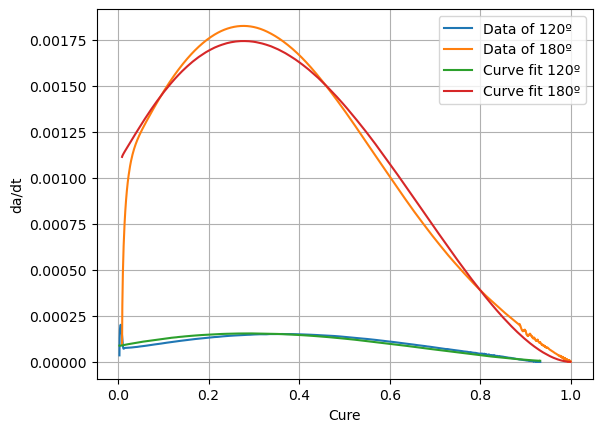

Relative difference between fitted curve and real curve for 120º=  0.4478284332092707 %
Relative difference between fitted curve and real curve for 180º=  0.06781761267471127 %


In [6]:
# Find other kaml_sourour parameters A2, E2, m and n
A2, E2, m, n = find_kamal_sour(dc_dt120, rT120, alpha_t_120, dc_dt180, rT180, alpha_t_180, A1, E1 )

Comment:

#### Question 5.3: The model you just made should be able to describe the behaviour of the resin at a cure temperature of $150^\circ$ C. Verify whether your model is able to estimate the behaviour of the resin at this cure temperature by generating a graph $\frac{d\alpha}{dt}$ vs degree of cure $\alpha$ for both the experimental data from Question 1 and your model. Finally, comment on the plot you obtained and on the accuracy of your model.

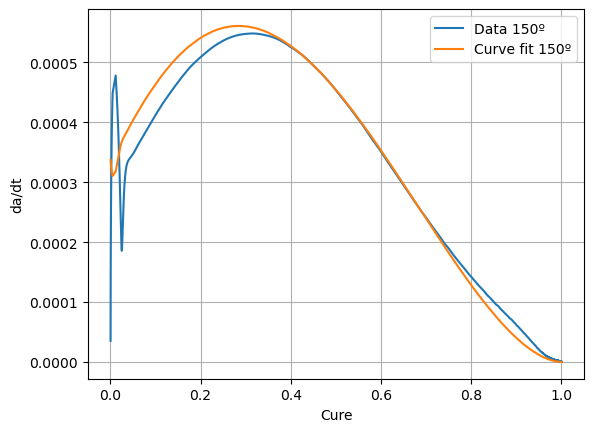

In [7]:
# Verify with the 150 curve
dc_dt150_fit = calc_da_dt(rT150, alpha_t_150, A1, E1, A2, E2, m, n)

plt.plot(alpha_t_150, dc_dt150, label ="Data 150º")
plt.plot(alpha_t_150, dc_dt150_fit, label = "Curve fit 150º")
plt.ylabel("da/dt")
plt.xlabel("Cure")
plt.grid()
plt.legend()
plt.show()

Comment:

## Question 6 (2 points)

#### As mentioned at the beginning of this Notebook, thermoset polymers undergo a curing cycle to achieve hardening. This process involves the formation of covalent bonds between monomers, ultimately resulting in the creation of the polymer network. The amount of formed bonds, therefore the degree of cross-linking, directly impacts the glass transition temperature ($T_g$) of the material. In the initial stages of the curing cycle, when relatively few bonds or crosslinks have formed, the material exhibits a relatively low $T_g$. However, as the degree of cure increases, the $T_g$ of the material increases. 

#### The correlation between $T_g$ and the degree of cure is particularly crucial in the design and engineering of polymer-based products, as it allows for the precise tuning of material properties by controlling the curing parameters. By adjusting the degree of cross-linking through cure temperature and time, engineers can achieve specific material characteristics, such as stiffness, strength, resistance to heat, and dimensional stability, tailored to the requirements of a particular application.

#### Describe the glass transition temperature and explain what happens (on a microscale and chemical level) when a material transitions through this value. Please include an explanation on how this value depends on  the degree of cure.

Answer: The glass transition temperature (Tg) marks the transition of a polymer from a hard, glassy state to a soft, rubbery state. Below the Tg, polymer chains are immobilized. Above the Tg, they gain enough thermal energy for segmental motion and rotation around bonds, increasing free volume and flexibility. Tg depends strongly on the degree of cure because additional cross-links from curing create a tighter molecular network that restricts chain movement. This requires more thermal energy to initiate motion, so higher cure levels result in higher Tg values.

## Question 7 (2 points)

#### For a thermosetting polymer, it is particularly relevant to have a model able to describe the physical changes encountered during the cure cycle.
#### The following empirical relation (Di Benedetto equation) between glass transition temperature $T_g$ and conversion $\alpha$ has this goal and identifies the vitrification limit of a polymer:
####  $$ \frac{T_g - T_{g0}}{T_{g\infty} - T_{g0}} =  \frac{\lambda \alpha}{1 - (1 - \lambda)\alpha}  $$

#### In which $\lambda = \frac{\Delta C_p}{\Delta C_{p0}}$ is the ratio of the heat capacities of the fully reacted system and the initial system (therefore $\lambda < 1$), $T_{g\infty}$ is the $T_g$ of the fully reacted system, and $T_{g0}$ is the $T_g$ of the initial system.

#### A dataset containing glass transition temperature $T_g$ and degree of cure $\alpha$ values for Airstone 780E was provided with this notebook.
#### Use the $T_{g}$ values to fit the model to the experimental data, find $\lambda$ and report its value below.
#### Generate a graph for the glass transition temperature $T_g$ vs. degree of cure $\alpha$ to compare experimental values with the analytical model.

#### NOTE: $T_{g0}$ = -54.577, $T_{g\infty}$ = 88.853,

Fitted λ = 0.529194005605318


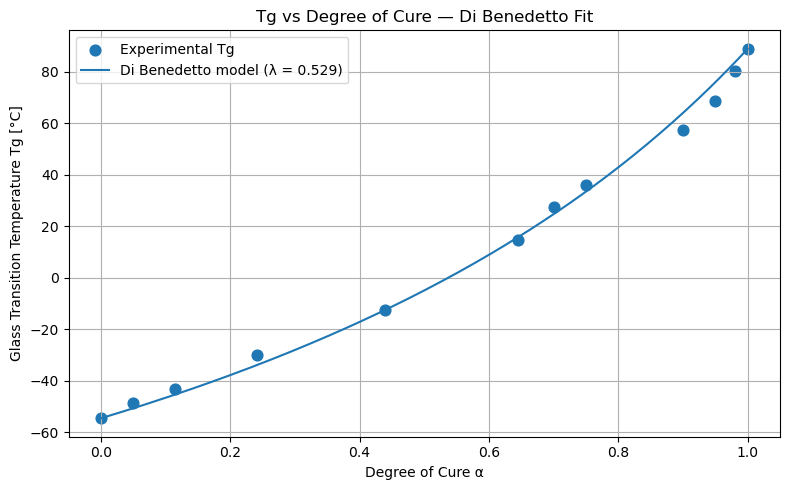

In [8]:
# -------------------------------------------------
# CONSTANTS GIVEN IN THE ASSIGNMENT
# -------------------------------------------------
Tg0 = -54.577
Tg_inf = 88.853

# -------------------------------------------------
# LOAD DATA
# -------------------------------------------------
path = "Tg data.xlsx"
df = pd.read_excel(path)

# Transpose to access α and Tg rows
dfT = df.T

# Extract raw alpha and Tg arrays
alpha_raw = pd.to_numeric(dfT.loc["Unnamed: 7", 1:], errors="coerce").values
Tg_raw = pd.to_numeric(dfT.loc["Unnamed: 8", 1:], errors="coerce").values

# -------------------------------------------------
# REMOVE NaN VALUES (minimal and necessary fix)
# -------------------------------------------------
mask = (~np.isnan(alpha_raw)) & (~np.isnan(Tg_raw))
alpha = alpha_raw[mask]
Tg_exp = Tg_raw[mask]

# Safety check
if len(alpha) == 0:
    raise RuntimeError("ERROR: All α–Tg pairs are NaN after cleaning. Check data formatting.")

# -------------------------------------------------
# DI BENEDETTO MODEL
# -------------------------------------------------
def Tg_model(alpha, lam):
    return Tg0 + (Tg_inf - Tg0) * (lam * alpha) / (1 - (1 - lam) * alpha)

# -------------------------------------------------
# FIT FOR λ
# -------------------------------------------------
popt, pcov = curve_fit(Tg_model, alpha, Tg_exp, bounds=(0,1))
lam_fit = popt[0]

print("Fitted λ =", lam_fit)

# -------------------------------------------------
# COMPUTE ANALYTICAL CURVE
# -------------------------------------------------
alpha_fit = np.linspace(0, 1, 200)
Tg_fit = Tg_model(alpha_fit, lam_fit)

# -------------------------------------------------
# PLOT
# -------------------------------------------------
plt.figure(figsize=(8,5))
plt.scatter(alpha, Tg_exp, label="Experimental Tg", s=60)
plt.plot(alpha_fit, Tg_fit, label=f"Di Benedetto model (λ = {lam_fit:.3f})")
plt.xlabel("Degree of Cure α")
plt.ylabel("Glass Transition Temperature Tg [°C]")
plt.title("Tg vs Degree of Cure — Di Benedetto Fit")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Question 8 (2 points)

#### The glass transition temperature is specifically relevant when trying to establish a range of temperatures over which a polymer is able to retain its mechanical properties. This range is commonly identified as "Service temperature" and in these conditions the polymer can perform its intended function without experiencing significant degradation or detrimental changes in its properties.

#### Two composite parts (A and B) have been previously manufactured by infusion using Airstone 780E, cured isothermally at $80^\circ$ C. It is known that the reached degree of cure at the end of the cycle for part A is $\alpha$= 0.9, while part B was consolidated up to $\alpha$= 0.95.
#### Use the DiBenedetto equation and the parameters given in question 7 to obtain the glass transition temperatures $T_g$ for the two parts. How would the difference between the $T_g$ of the two parts affect their properties and potential use temperature.

In [10]:
alpha_A = 0.90
alpha_B = 0.95

Tg_A = Tg_model(alpha_A, lam_fit)
Tg_B = Tg_model(alpha_B, lam_fit)

print(f"Tg for Part A (alpha = 0.90): {Tg_A:.2f} °C")
print(f"Tg for Part B (alpha = 0.95): {Tg_B:.2f} °C")
print(f"Difference: {Tg_B - Tg_A:.2f} °C")


Tg for Part A (alpha = 0.90): 63.96 °C
Tg for Part B (alpha = 0.95): 75.88 °C
Difference: 11.91 °C


Comment:
Using the Di Benedetto equation with λ = 0.529, the glass transition temperatures of the two parts cured at 80 °C were calculated from their final degrees of cure. Part A, cured to α = 0.90, has a Tg of about 64 °C, while Part B, cured to α = 0.95, reaches about 75.8 °C. This difference of more than 12 °C is significant because Tg defines the temperature above which the polymer loses stiffness and its mechanical properties begin to degrade. Part B can therefore operate safely at higher temperatures and is more resistant to softening and deformation. This shows that even a small increase in the degree of cure can noticeably improve the thermal and mechanical stability of a thermoset composite.

## Question 9 (4 points)

#### The cure kinetics model applicable to the Airstone 780E mentioned in Question 8, is given below:
#### $$\frac{d\alpha}{dt} = \frac{A \cdot exp(-\frac{E}{RT})}{1+exp(C(\alpha - \alpha_{c} -\alpha_{T}T)) }(1 - \alpha)^n\cdot \alpha^m$$
#### Where:
#### A = 681085 1/s
#### E = 59291 J/mol
#### n = 1.67
#### m = 0.12
#### C = 47.7
#### $\alpha_{c}$= 0.77
#### $\alpha_{T}$ = 0.0016


#### Question 9.1: Using the cure kinetics model, calculate the cure time for an isothermal cure at $80^\circ$ C to cure the part to 90% degree of cure (part A of Question 8). Compare this to the cure time needed to cure the part to 95% degree of cure at $80^\circ$ C (part B from Question 8). Please give your view on the trade-off between cure time and attainable $T_g$ (see also question 8).

Reached α=0.9 at 83.63 minutes
Reached α=0.95 at 143.62 minutes


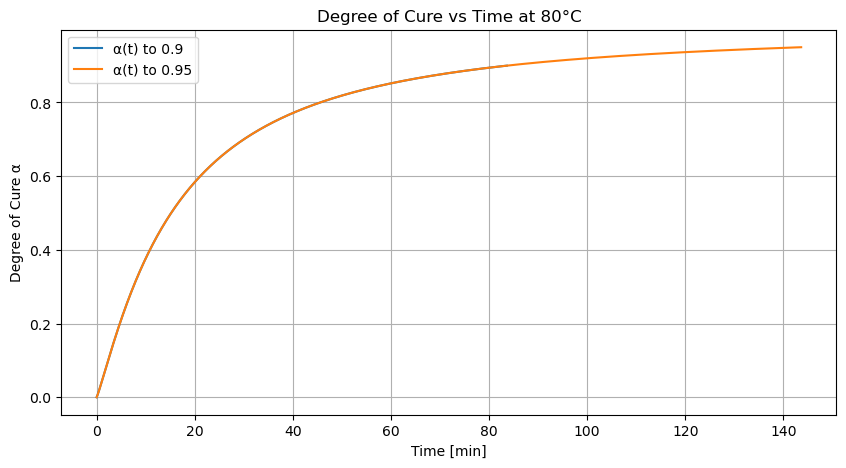

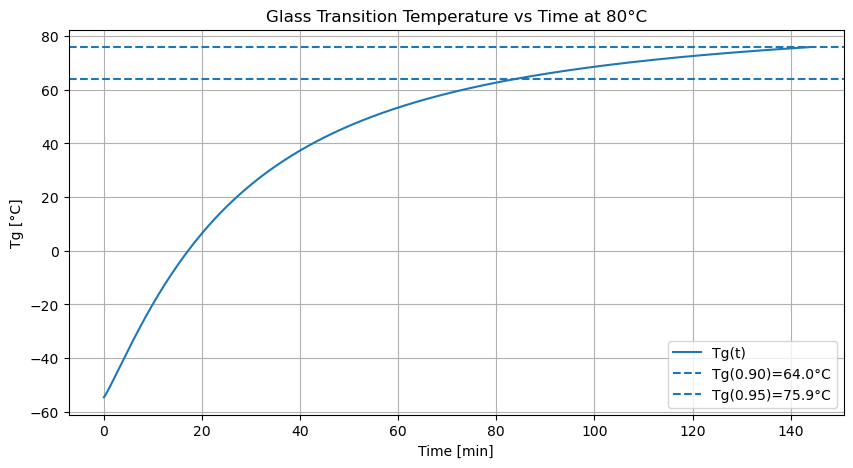

In [17]:
# Cure kinetics parameters
A = 681085.0
E = 59291.0
n = 1.67
m = 0.12
C = 47.7
alpha_c = 0.77
alpha_T = 0.0016
R = 8.314

T_C = 80.0
T = T_C + 273.15

def cure_rate(t, y):
    a = float(y[0])
    rate = (
        A * np.exp(-E / (R * T))
        / (1 + np.exp(C * (a - alpha_c - alpha_T * T)))
        * (1 - a)**n
        * (a**m if a > 0 else 0.0)
    )
    return [rate]

def make_event(alpha_target):
    def event(t, y): return y[0] - alpha_target
    event.terminal = True
    event.direction = 1
    return event

def integrate_to_target(alpha_target, alpha0=1e-6):
    sol = solve_ivp(
        cure_rate,
        t_span=(0, 1e6),
        y0=[alpha0],
        events=make_event(alpha_target),
        max_step=0.10,
        rtol=1e-6, atol=1e-9
    )
    return sol

alpha_targets = [0.90, 0.95]
results = {}

for tgt in alpha_targets:
    sol = integrate_to_target(tgt)
    results[tgt] = sol
    if sol.t_events[0].size > 0:
        t_event = sol.t_events[0][0]
        print(f"Reached α={tgt} at {t_event/60:.2f} minutes")
    else:
        print(f"Did not reach α={tgt}")

# ---------------------------------------------------------
# PLOT α(t)
# ---------------------------------------------------------
plt.figure(figsize=(10,5))
for tgt in alpha_targets:
    sol = results[tgt]
    t_h = sol.t / 60
    plt.plot(t_h, sol.y[0], label=f"α(t) to {tgt}")
plt.xlabel("Time [min]")
plt.ylabel("Degree of Cure α")
plt.grid(True)
plt.legend()
plt.title("Degree of Cure vs Time at 80°C")
plt.show()

# ---------------------------------------------------------
# PLOT Tg(t)
# ---------------------------------------------------------
sol_ref = results[0.95]
alpha_t = sol_ref.y[0]
t_h = sol_ref.t / 60

Tg_t = Tg_model(alpha_t, lam_fit)
Tg_A = Tg_model(0.90, lam_fit)
Tg_B = Tg_model(0.95, lam_fit)

plt.figure(figsize=(10,5))
plt.plot(t_h, Tg_t, label="Tg(t)")
plt.axhline(Tg_A, linestyle='--', label=f"Tg(0.90)={Tg_A:.1f}°C")
plt.axhline(Tg_B, linestyle='--', label=f"Tg(0.95)={Tg_B:.1f}°C")
plt.xlabel("Time [min]")
plt.ylabel("Tg [°C]")
plt.grid(True)
plt.legend()
plt.title("Glass Transition Temperature vs Time at 80°C")
plt.show()

Reflection: It requires an additional hour of curing at 80 degree to go from 90% to 95% and as can be seen in the graphs both seem to go assymptotic, meaning that with the additional hour of curing the benefit becomes smaller and smaller. 
The trade-off that needs to be made is wheter the additional increase of 11.9 degrees in Tg is required for this application, because this hour of curing requires a lot of energy, which in turn will cost a lot of money (also the additional time the curing chamber is not available). If the additional Tg is required it might be interesting to do a two step cure with a higher second temperature, e.g. after 60 min raise the temperature to 110-120 degrees and do a shorter cycle (20-30 min). This might be a cheaper solution compared to running it at 80 degrees for 144 minutes

#### Question 9.2: The production team needs to speed up production to a cure time of 60 minutes while reaching 95% degree of cure in the part. Which temperature would be needed to achieve this? Then, comment on the feasibility of using this cure temperature: which considerations and/or concerns would you share with the production team prior to implementation of this cure temperature?

===== Q9.2 Result =====
Required temperature for α = 0.95 in ≤ 60 min: 96.10 °C
Predicted cure time at this T: 59.54 min


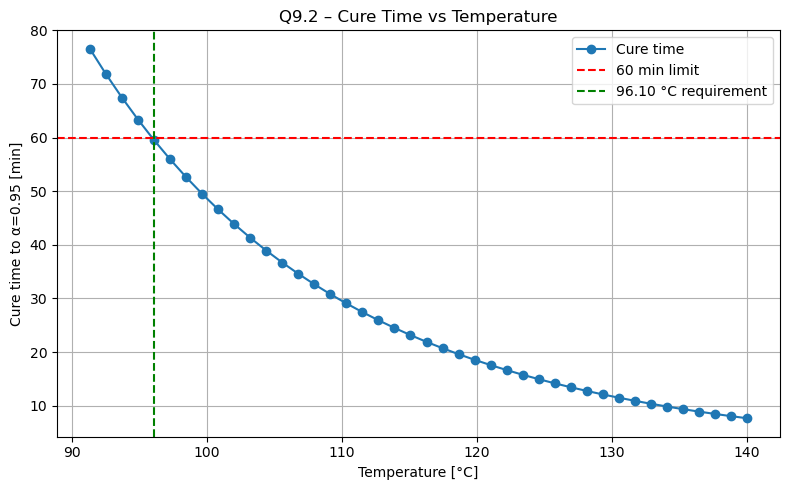

In [29]:
# ---------------------------------------------------------
# Cure rate function for Q9.2 (unique function name)
# ---------------------------------------------------------
def cure_rate_q92(t, y, T):
    alpha = y[0]
    if alpha <= 0:
        alpha = 1e-9
    term1 = A * np.exp(-E / (R * T))
    term2 = 1 + np.exp(C * (alpha - alpha_c - alpha_T * T))
    return [term1 / term2 * (1 - alpha)**n * alpha**m]

# ---------------------------------------------------------
# Fast two-phase solver:
#   Phase 1: large steps until 60 min
#   Phase 2: fine steps if needed to reach α_target
# ---------------------------------------------------------
def cure_time_q92(T_C, alpha_target=0.95, t_limit=3600.0):
    T_K = T_C + 273.15

    # Event triggers when α reaches target
    def event_target(t, y): 
        return y[0] - alpha_target
    event_target.terminal = True
    event_target.direction = 1

    # ---- Phase 1: FAST integration to 60 min ----
    sol1 = solve_ivp(
        fun=lambda t, y: cure_rate_q92(t, y, T_K),
        t_span=(0, t_limit),
        y0=[1e-6],
        max_step=5.0,       # fast but safe
        rtol=1e-5,
        atol=1e-8,
        events=event_target
    )

    # If α already reached in Phase 1 → done
    if sol1.t_events[0].size > 0:
        return float(sol1.t_events[0][0])

    alpha_60 = float(sol1.y[0, -1])

    # If still below α_target → give time = 60 min (requirement)
    # Production can cure LONGER, but must be <= 60 min for rating.
    if alpha_60 >= alpha_target:
        return t_limit  

    # ---- Phase 2: Continue briefly past 60 min, but only until α reaches target ----
    sol2 = solve_ivp(
        fun=lambda t, y: cure_rate_q92(t, y, T_K),
        t_span=(t_limit, t_limit + 1200),   # max 20 extra min if needed
        y0=[alpha_60],
        max_step=0.1,       # accurate refinement
        rtol=1e-7,
        atol=1e-10,
        events=event_target
    )

    # If target α reached in extra time
    if sol2.t_events[0].size > 0:
        return float(sol2.t_events[0][0])

    # Otherwise α_target not achievable even with +20 min
    return np.inf


# ---------------------------------------------------------
#   Temperature scan to find required T
# ---------------------------------------------------------
temps = np.linspace(70, 140, 60)   # coarse grid
times = np.array([cure_time_q92(T) for T in temps])

# Find first temperature that cures within 60 minutes
mask = times <= 3600
if np.any(mask):
    T_required = temps[mask][0]
else:
    T_required = None

# ---------------------------------------------------------
#   Print result
# ---------------------------------------------------------
print("===== Q9.2 Result =====")
if T_required is None:
    print("No temperature in the tested range achieves α = 0.95 in ≤ 60 min.")
else:
    print(f"Required temperature for α = 0.95 in ≤ 60 min: {T_required:.2f} °C")
    print(f"Predicted cure time at this T: {times[mask][0]/60:.2f} min")

# ---------------------------------------------------------
#   Plot
# ---------------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(temps, times/60, "o-", label="Cure time")
plt.axhline(60, color="r", linestyle="--", label="60 min limit")

if T_required is not None:
    plt.axvline(T_required, color="g", linestyle="--", 
                label=f"{T_required:.2f} °C requirement")

plt.xlabel("Temperature [°C]")
plt.ylabel("Cure time to α=0.95 [min]")
plt.title("Q9.2 – Cure Time vs Temperature")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Comment: The main problems with raising the temperature will be in:
1) Thermal degradation
2) Outgassing
3) Uneven cure in thick sections
4) Increased residual stress

How to go about testing this:
1) Create test set-up
    a) Thermocouples
    b) Verify Tg
    c) Verify mechanical properties
    d) Check oven (temperature, distribution)
    e) QC
Thus before implementation get the production team to run a trial run and check all components, if this results in parts that pass QC, the production team can continue with this method. If the parts do not pas QC, then double check the process and see if a 2 step cure cycle or a post cure might work, these are usually lower-risk compared to single cure.    
